In [1]:
__file__ = 'A1.ipynb'
import sys
import pathlib
sys.path.append(str(pathlib.Path(__file__).absolute().parent.parent)+"/FP4_lib")
import functions as f
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from uncertainties import unumpy as up
from uncertainties import ufloat
import scipy.constants as const
import scipy.fft as fft
import lmfit

In [2]:
with open('Data/Aufg_6.2.txt','r') as tf:
    data = np.genfromtxt(tf).T
with open('Res/cp-cal_res.txt','r') as tf:
    cal = np.genfromtxt(tf).T
for i in range(len(data[1])):
    data[0][i]-= 616800

data = f.channel_to_pos(data,cal)

In [3]:
yerr = 0.035339825186025027*np.abs(data[1])
print(np.mean(data[2]))

0.001889517934223693


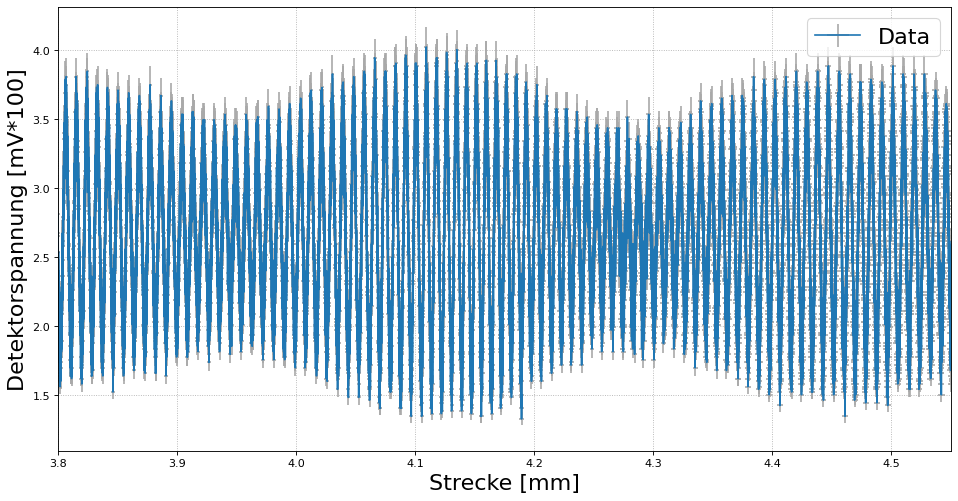

In [4]:
f.figsize(2)
plt.errorbar(data[0],data[1],yerr=yerr,xerr=data[2],label = 'Data',ecolor='darkgray')

f.form([3.8,4.55],xlabel='Strecke [mm]',ylabel='Detektorspannung [mV*100]',name='Res/A6_interferogramm.pdf')

Wavelength: 3.4796973315675905e-06 m


/tmp/ipykernel_20238/3468660758.py:20: RuntimeWarning: divide by zero encountered in divide
  freqs = 1/freqs


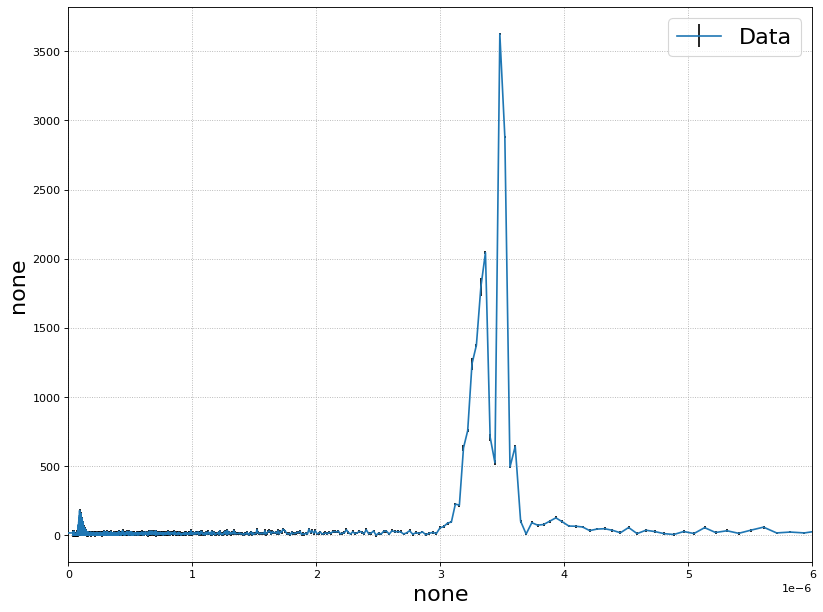

In [5]:
freq_scale = 2/5.127868608985219*1e-3

intensity = data[1]
position  = data[0]*freq_scale


intensity -= np.mean(intensity)


freqs = np.fft.fftfreq(len(intensity), d=((np.mean(np.diff(position)))))
fft_int = np.fft.fft(intensity)
fft_err = np.fft.fft(yerr).clip(10)

peak_idx = np.argmax(np.abs(fft_int))
peak_freq = freqs[peak_idx]


print(f"Wavelength: {1/peak_freq} m")

freqs = 1/freqs

f.figsize(1)

plt.errorbar(freqs, np.abs(fft_int),yerr=np.abs(fft_err),ecolor='k',zorder=10,label='Data')
plt.xlim(0,0.6e-5)



#plt.vlines(3.6271e-06,0,3600,colors="r")
#plt.vlines(3.4007e-06,0,3600,colors="b")

f.form()

In [6]:
dat = [freqs, np.abs(fft_int),np.abs(fft_err)]

sorted_indices = sorted(range(len(dat[0])), key=lambda k: dat[0][k])

dat_sorted = [[dat[0][i], dat[1][i],dat[2][i]] for i in sorted_indices]

dat_sorted = np.array(dat_sorted).T

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 13
    # variables        = 3
    chi-square         = 2913.63871
    reduced chi-square = 291.363871
    Akaike info crit   = 76.3587123
    Bayesian info crit = 78.0535604
    R-squared          = 0.99945642
[[Variables]]
    amplitude:  3.8792e-04 +/- 3.8793e-05 (10.00%) (init = 0.0003224966)
    center:     3.3365e-06 +/- 9.7777e-09 (0.29%) (init = 3.309059e-06)
    sigma:      8.3388e-08 +/- 1.0035e-08 (12.03%) (init = 5.425335e-08)
    fwhm:       1.9636e-07 +/- 2.3630e-08 (12.03%) == '2.3548200*sigma'
    height:     1855.88123 +/- 148.925145 (8.02%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = 0.750
    C(center, sigma)     = 0.496
    C(amplitude, center) = 0.473
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals  

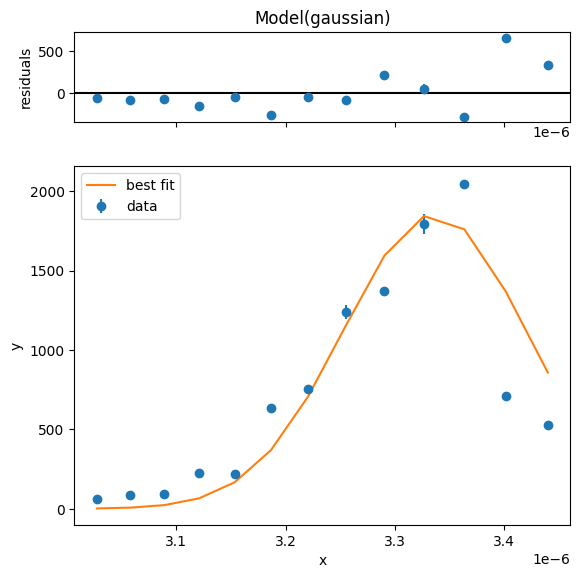

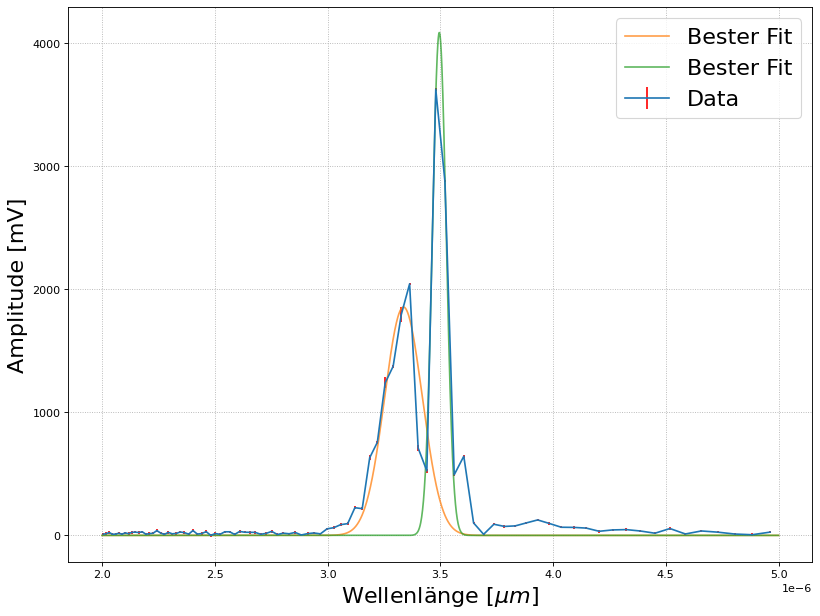

In [12]:
von,bis = f.pos(dat_sorted[0],0.2e-5),f.pos(dat_sorted[0],0.5e-5)
von1,bis1 = f.pos(dat_sorted[0],0.3e-5),f.pos(dat_sorted[0],0.345e-5)#0.3425e-5)
von2,bis2 = f.pos(dat_sorted[0],0.341e-5),f.pos(dat_sorted[0],0.37e-5)






res1 = f.gausfit(dat_sorted[1,von1:bis1],dat_sorted[0,von1:bis1],dat_sorted[2,von1:bis1])
res1.plot()
print(res1.fit_report())

res2 = f.gausfit(dat_sorted[1,von2:bis2],dat_sorted[0,von2:bis2],dat_sorted[2,von2:bis2])
#res2.plot()
print(res2.fit_report())


plt.show()
f.figsize(1)

plt.errorbar(dat_sorted[0,von:bis],dat_sorted[1,von:bis],yerr=dat_sorted[2,von:bis],ecolor = 'r',label='Data')
plt.plot(np.arange(2e-6,5e-6,1e-9),res1.eval(x=np.arange(2e-6,5e-6,1e-9)),alpha=0.75,label='Bester Fit')#,color='y')
plt.plot(np.arange(2e-6,5e-6,1e-9),res2.eval(x=np.arange(2e-6,5e-6,1e-9)),alpha=0.75,label='Bester Fit')#,color='y')

f.form(xlabel=f'Wellenlänge [$\mu m$]',ylabel='Amplitude [mV]',name='Res/A6_fftfit.pdf')


[[Model]]
    (Model(gaussian, prefix='g1_') + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 56
    # data points      = 46
    # variables        = 6
    chi-square         = 245589.128
    reduced chi-square = 6139.72821
    Akaike info crit   = 406.807595
    Bayesian info crit = 417.779444
    R-squared          = 0.99104303
##  Warning: uncertainties could not be estimated:
    g1_center:     at initial value
    g2_center:     at initial value
[[Variables]]
    g1_amplitude:  607607.442 (init = 2000)
    g1_center:     3.3000e-06 (init = 3.3e-06)
    g1_sigma:      128.415683 (init = 0.3)
    g2_amplitude: -120527.639 (init = 3500)
    g2_center:     3.5000e-06 (init = 3.5e-06)
    g2_sigma:      31.0266278 (init = 0.3)
    g1_fwhm:       302.395820 == '2.3548200*g1_sigma'
    g1_height:     1887.62232 == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2_fwhm:       73.0621237 == '2.3548200*g2_sigma'
    g2_height: 

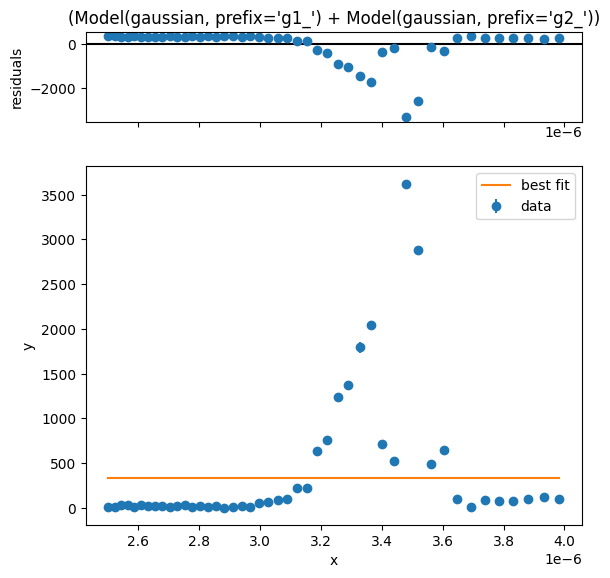

In [8]:
von,bis = f.pos(dat_sorted[0],0.2e-5),f.pos(dat_sorted[0],0.5e-5)
von1,bis1 = f.pos(dat_sorted[0],0.25e-5),f.pos(dat_sorted[0],0.4e-5)


model_gaus3 = lmfit.models.GaussianModel(prefix='g1_')+lmfit.models.GaussianModel(prefix='g2_')
    
pars_gaus3=model_gaus3.make_params()
pars_gaus3['g1_amplitude'].set(2000)
pars_gaus3['g1_center'].set(3.3e-6,min=3.2e-6,max=3.41e-6)
pars_gaus3['g1_sigma'].set(0.3)

pars_gaus3['g2_amplitude'].set(3500)
pars_gaus3['g2_center'].set(3.5e-6,min=3.41e-6,max=3.6e-6)
pars_gaus3['g2_sigma'].set(0.3)

out_gaus = model_gaus3.fit(dat_sorted[1,von1:bis1],x=dat_sorted[0,von1:bis1],weights=1/dat_sorted[2,von1:bis1].clip(1),params=pars_gaus3,nan_policy='propagate')


#plt.errorbar(dat_sorted[0,von:bis],dat_sorted[1,von:bis],yerr=dat_sorted[2,von:bis],ecolor = 'k')
out_gaus.plot()
print(out_gaus.fit_report())
